<img src="./images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Classical Optimization*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the Quantum Experience consult the [Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0) or check-out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Jay Gambetta, Antonio Mezzacapo

## Introduction

NP-Complete problems are very important. Here we show a method that is very similar to CITE[Fahri] recent paper. 

Here we propose that we map the cost function of the problem to a Hamiltonian of the form

$$ H = \alpha_i Z_i + \beta_{i,j} Z_jZ_i + \gamma_{i,j,k}Z_kZ_jZ_i +... $$

and the goal is to find the configuration that minimizes the energy.

The trial functions we propose using are of the form 

$$|\psi(\theta)\rangle  = [U_\mathrm{single}(\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a function of cPhase gates and $U_\mathrm{single}(\theta) = X(\theta)^{\otimes n}$

In [2]:
#Checking the version of PYTHON we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
#usefull additional packages 
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg
%matplotlib inline
import time

#importing the QX and QISKit 
from IBMQuantumExperience import IBMQuantumExperience
import sys
sys.path.append("..")
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.extensions.standard import x, h, cx, s, u3, barrier, cz

#some usefull functions for running a program, plotting, and getting the data
from qhelpers.misc import run_program
from qhelpers.misc import program_to_text
from qhelpers.misc import combine_jobs
from qhelpers.misc import get_data
from qhelpers.basicplotter import plot_histogram
from qhelpers.misc import average_data
from tools.quantum_optimization import cost_classical

#Set up the API to communitcate to the QX
import Qconfig
api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken, Qconfig.config)

In [6]:
n=5 #number of qubits
device = 'simulator' # the device to run on
shots = 1024    #the number of shots in the experiment. 

#making a classical trial function 
q = QuantumRegister("q", n)
c = ClassicalRegister("c", n)
trial_circuit = QuantumCircuit(q, c)
trial_circuit.x(q[0])
trial_circuit.x(q[3])
trial_circuit.x(q[4])
for j in range (n):
    trial_circuit.measure(q[j], c[j])


#making a program to run
program = [trial_circuit]
out = run_program(program,api,device,shots,max_credits=3)
jobids=[out['id']]
results=combine_jobs(jobids, api, wait=20, timeout=240)  

#cost function
alpha = np.zeros(5)
alpha[4] = 1
beta = np.zeros((5,5))
beta[0,1]=0.5
beta[1,0]=0.5
beta[0,2]=0.5
beta[2,0]=0.5
beta[1,2]=0.5
beta[2,1]=0.5
beta[1,3]=0.5
beta[3,1]=0.5
beta[2,3]=0.5
beta[3,2]=0.5

data=get_data(results,0)
cost_classical(data,n,alpha,beta)

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


-4.0

In [3]:
def trial_funtion_optimization(q,c,n,m,theta):
    """trial function. 
    q = quantum register 
    c = classical register 
    n = number of qubits
    m = depth
    theta = control vectors n*i+j where j counts the qubits and i the depth 
    """
    trial_circuit = QuantumCircuit(q, c)
    trial_circuit.h(q)
    for i in range (m):
        trial_circuit.barrier(q)
        trial_circuit.cz(q[0],q[2])
        trial_circuit.cz(q[1],q[2])
        trial_circuit.cz(q[3],q[2])
        trial_circuit.cz(q[4],q[2])
        for j in range (n):
            trial_circuit.u3(theta[n*i+j],-np.pi/2,np.pi/2,q[j])
    for j in range (n):
        trial_circuit.measure(q[j], c[j])
    return trial_circuit

In [8]:
device = 'simulator' # the device to run on
shots = 1024    #the number of shots in the experiment. 

#quantum circuit 
n=5 # number of qubits has to be 5. I fix this later
q = QuantumRegister("q", n)
c = ClassicalRegister("c", n)
m = 1 # the depth of the circuit

theta = np.zeros(m*n)
trial_circuit = trial_funtion_optimization(q,c,n,m,theta)

program = [trial_circuit]

out = run_program(program,api,device,shots,max_credits=3)
jobids=[out['id']]
results=combine_jobs(jobids, api, wait=20, timeout=240)  
cost_classical(get_data(results,0),n,alpha,beta)

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


-0.01953125

In [45]:
device = 'simulator' # the device to run on
shots = 8192    #the number of shots in the experiment. 


#quantum circuit 
n=5 # number of qubits has to be 5. I fix this later
q = QuantumRegister("q", n)
c = ClassicalRegister("c", n)
m = 1 # the depth of the circuit

SPSA_parameters = np.array([2,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
theta_start = np.zeros(m*n)+np.pi/2 # intial controls 
max_trials = 50;
# k loop
theta = theta_start
cost_plus=np.zeros(max_trials)
cost_minus=np.zeros(max_trials)
for k in range(max_trials):
    print('trial ' + str(k) + " of " + str(max_trials))
    a_spsa = float(SPSA_parameters[0])/np.power(k+1+SPSA_parameters[2], SPSA_parameters[1])
    c_spsa = float(SPSA_parameters[3])/np.power(k+1, SPSA_parameters[4])

    Delta = 2*np.random.randint(2,size=n*m)-1 # \pm 1 random distribution 
    theta_plus = theta + c_spsa*Delta
    theta_minus = theta - c_spsa*Delta

    trial_circuit_plus = trial_funtion_optimization(q,c,n,m,theta_plus)
    trial_circuit_minus = trial_funtion_optimization(q,c,n,m,theta_minus)

    program = [trial_circuit_plus,trial_circuit_minus]
    out = run_program(program,api,device,shots,max_credits=3)
    results=combine_jobs([out['id']], api, wait=20, timeout=240)  
    cost_plus[k] = cost_classical(get_data(results,0),n,alpha,beta)
    cost_minus[k] = cost_classical(get_data(results,1),n,alpha,beta)
    g_spsa = (cost_plus[k]-cost_minus[k])*Delta/(2.0*c_spsa)
    theta = theta - a_spsa*g_spsa

trial_circuit =  trial_funtion_optimization(q,c,n,m,theta) 
program = [trial_circuit]
out = run_program(program,api,device,shots,max_credits=3)
results=combine_jobs([out['id']], api, wait=20, timeout=240)  
cost = cost_classical(get_data(results,0),n,alpha,beta)

trial 0 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 1 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 2 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 3 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 4 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 5 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 6 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 7 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 8 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 9 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 10 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 11 of 50
statu

-0.0234375


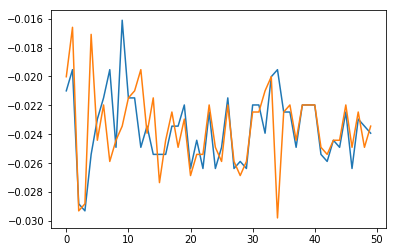

In [46]:
plt.plot(range(max_trials), cost_plus,range(max_trials),cost_minus)
print(cost)